# **Astrophysical Computations & Algorithms**
## *TA Week 6*

- ### *Quiz annoucements (4/16)*
  범위 : Week1 ~ Week3 (TA Class 포함) 

  오프라인(필기구 지참), 시간 10분

- ### *4/9 출석확인*
  4/9 이내에 수업 영상 시청 완료 및 요약 보고서 제출

## **HW7**
<img src='HW7.png' width='600'>

### Strategy
- 파일 읽기
- 100개 구간으로 균등분할 (np.linspace)
- Linear interpolation 함수 정의하기
  - 보간에 사용할 두 점(subscript 1,2)을 어떻게 찾을까?

### Read `sn.dat`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

<img src='interp_1d.png' width=600>

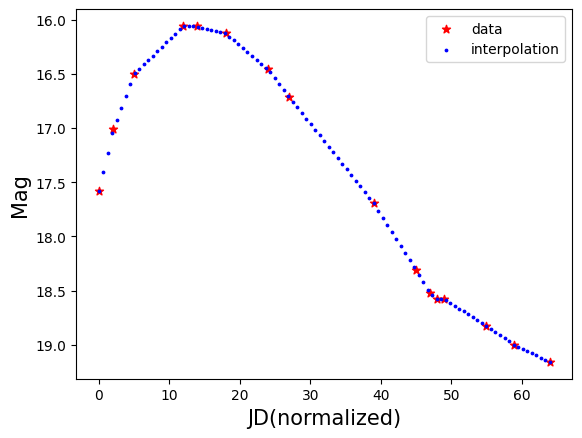

In [2]:
df = pd.read_csv('sn.dat', sep='\s+')

# 시간의 흐름을 보기 편하게 첫 데이터의 JD를 0으로 normalize
df['JD_from0'] = df['JD'] - df['JD'][0]

x_interpolation = np.linspace(df['JD_from0'].min(), df['JD_from0'].max(), 101)
linear_interpolator = interp1d(df['JD_from0'], df['Mag'])
y_interpolation = linear_interpolator(x_interpolation)

plt.scatter(df['JD_from0'], df['Mag'], c='red', label='data', marker='*')
plt.scatter(x_interpolation, y_interpolation, s=3, c='blue', label='interpolation')
plt.gca().invert_yaxis()
plt.xlabel('JD(normalized)', fontdict={'size':15}); plt.ylabel('Mag', fontdict={'size':15})
plt.legend()

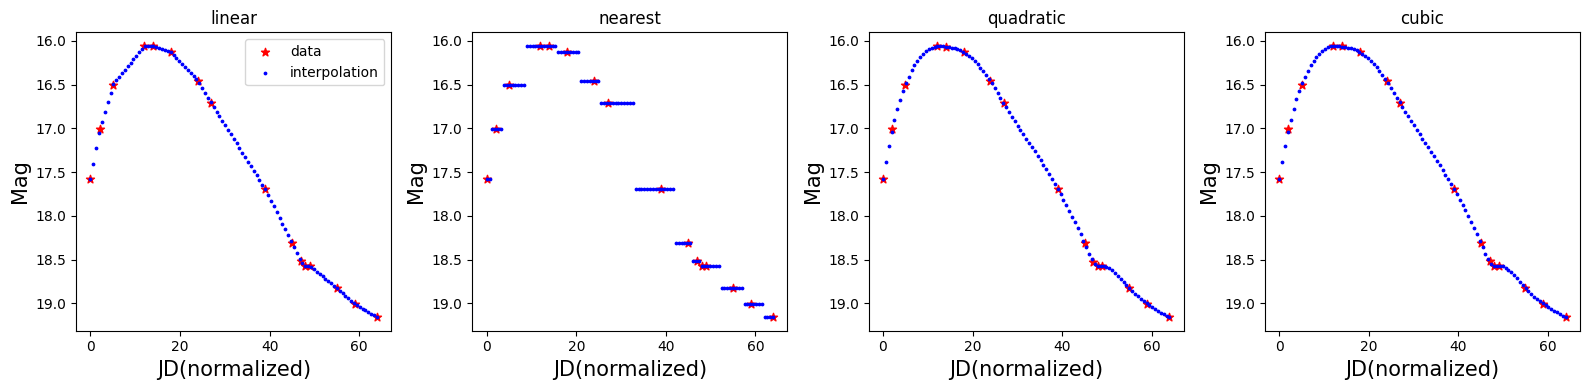

In [3]:
kinds = ['linear', 'nearest', 'quadratic', 'cubic']
x_interpolation = np.linspace(df['JD_from0'].min(), df['JD_from0'].max(), 101)

fig, ax = plt.subplots(1,4, figsize=(16,4))
for i, kind in enumerate(kinds):
    interpolator = interp1d(df['JD_from0'], df['Mag'], kind=kind)
    y_interpolation = interpolator(x_interpolation)

    ax[i].scatter(df['JD_from0'], df['Mag'], c='red', label='data', marker='*')
    ax[i].scatter(x_interpolation, y_interpolation, s=3, c='blue', label='interpolation')
    ax[i].set_xlabel('JD(normalized)', fontdict={'size':15}); ax[i].set_ylabel('Mag', fontdict={'size':15})
    ax[i].set_title(kind)
    ax[i].invert_yaxis()
ax[0].legend()
plt.tight_layout()

### `Scipy.interpolator.interp1d`는 interpolation할 위치를 어떻게 찾을까?

<img src='interp1d_call_linear.png' width='600'>

<img src='searchsorted.png' width='800'>

<img src='Binary-search-work.gif'>

### Linear serach vs. Binary search

In [4]:
def linear_search(data, interp_points):
    interp_idxs = np.full(len(interp_points), np.nan)
    for i, interp in enumerate(interp_points):
        for j in range(len(data)):
            if data[j] > interp:
                interp_idxs[i] = j
                break
    return interp_idxs

def binary_search(data, interp_points):
        interp_idxs = np.full(len(interp_points), np.nan)
        for i, interp in enumerate(interp_points):
            low, high = 0, len(data)
            while low < high:
                mid = (low + high) // 2
                if data[mid] < interp:
                    low = mid + 1
                else:
                    high = mid
            interp_idxs[i] = low
        return interp_idxs

In [5]:
a = [1,3,5,7,9]
b = [2,4,6,8]

print(binary_search(a,b))
print(linear_search(a,b))

[1. 2. 3. 4.]
[1. 2. 3. 4.]


In [6]:
import time

In [7]:
N = np.array([1000, 10000, 100000, 1000000])
repeats = 10
t_linear = np.zeros((repeats, len(N))); t_binary = np.zeros((repeats, len(N)))

for repeat in range(repeats):
    for i, n in enumerate(N):
        a = np.linspace(0,10000, n)
        b = np.random.uniform(1,10000, 1000)

        t1 = time.time()
        result = linear_search(a,b)
        t2 = time.time()
        t_linear[repeat, i] = t2-t1

        t1 = time.time()
        result = binary_search(a,b)
        t2 = time.time()
        t_binary[repeat, i] = t2-t1

t_linear = np.mean(t_linear, axis=0); t_binary = np.mean(t_binary, axis=0)

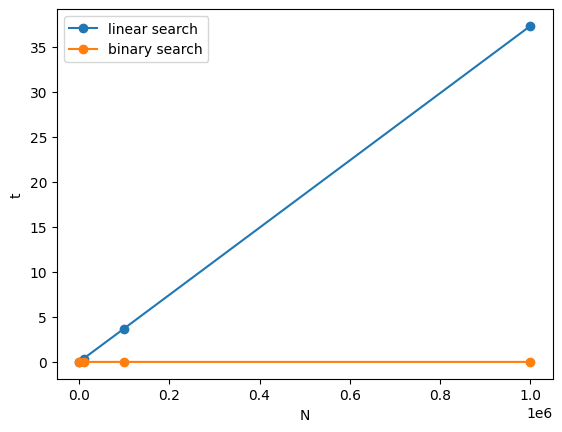

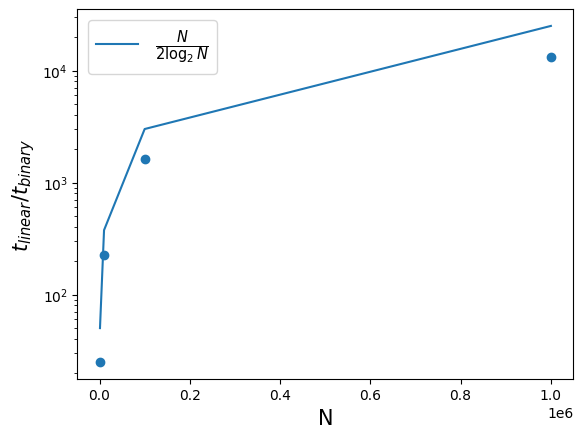

In [8]:
plt.plot(N, t_linear, label='linear search', marker='o'); plt.plot(N, t_binary, label='binary search', marker='o')
plt.xlabel('N'); plt.ylabel('t')
plt.legend(); plt.show()

plt.scatter(N, t_linear/t_binary)
diff_expected = (N/2)/np.log2(N)
plt.plot(N,diff_expected, label=r'$\frac{N}{2\log_2 N}$')
plt.xlabel('N', fontdict={'size':15}); plt.ylabel(r'$t_{linear}/t_{binary}$', fontdict={'size':15})
plt.yscale('log')
plt.legend(fontsize=15)

## **HW8**

<img src='HW8.png' width='500'>

### Neville's algorithm

<img src='neville.png' width='600'>

<img src='neville_formula.png' width='800'>

In [9]:
def neville(XData, yData, x) : 
    m = len(XData)
    y = yData.copy()
    for k in range(1,m):
        y[0:m-k] = ((x-XData[k:m])*y[0:m-k] + (XData[0:m-k]-x)*y[1:m-k+1]) / (XData[0:m-k] - XData[k:m])

m = interpolation에 사용할 data 개수 (보간차수+1)

y = yData.copy() -> $P_{i,i+1,...,i+m}$ 을 위한 array를 따로 만들지 않고 yData를 copy하여 사용
$(\because P_0,\ P_1,\ ...,\ P_m = y_0,\ y_1,\ ...,\ y_m )$

그리고 P를 계산에 한 번 사용하고 나면 앞으로는 필요가 없어짐. yData.copy() 에 덮어씌워도 무방.

Array의 장점인 element-wise 계산으로 반복문을 2번 사용하지 않고 한번에 처리.

#원하는 보간 차수에 맞는 input XData, yData를 넣어줘야함. 혹은 def neville() 안에 해당 기능을 추가

## **HW9 & HW10**

<img src='HW9.png' width='400'>
<img src='HW10.png' width='400'>

### `FITS` file
FITS (Flexible Image Transport System)는 천문학 데이터 교환을 위해 널리 사용되는 포맷.  
주로 천체 이미지, 스펙트럼, 표 형식 데이터 등을 저장하기 위함.

---

#### Why FITS?
- 메타데이터 저장 가능 (관측 날짜, 망원경 정보, 노출 시간 등)
- 다차원 데이터 지원 (이미지, 스펙트럼, 큐브 등)

---

#### FITS structure
<img src='fits_structure.png' width='400'>

###### Credit https://www.stsci.edu/hst/wfpc2/Wfpc2_dhb/intro_ch23.html

---



In [10]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt

In [11]:
hdu = fits.open('image1.fits')
print(type(hdu))

<class 'astropy.io.fits.hdu.hdulist.HDUList'>


In [12]:
# HDUList class의 info() method
hdu.info()

Filename: image1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (100, 100)   uint8   


In [13]:
type(hdu[0])

astropy.io.fits.hdu.image.PrimaryHDU

In [14]:
# .header attribute로 헤더에 접근 가능
hdu[0].header

SIMPLE  =                    T /Primary Header created by MWRFITS v1.11         
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  100 /                                                
NAXIS2  =                  100 /                                                
EXTEND  =                    T /Extensions may be present                       

In [15]:
# .data attribute로 data에 접근 가능
hdu[0].data

array([[209, 190, 213, ...,  47,  47,  39],
       [154, 178, 199, ...,  44,  52,  67],
       [208, 216, 227, ...,  48,  51,  53],
       ...,
       [134, 134, 133, ..., 106, 105, 106],
       [133, 133, 132, ..., 104, 105, 104],
       [132, 131, 130, ..., 103, 104, 103]], dtype=uint8)

In [16]:
image1 = hdu[0].data

### `plt.imshow()`

<img src='images.png' width='600'>

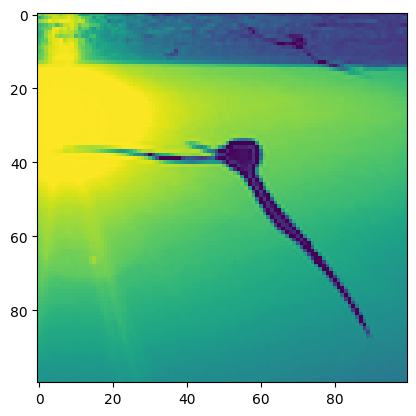

In [17]:
plt.imshow(image1)
# different color, inverted image
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

### `plt.savefig()`, `.writeto()`

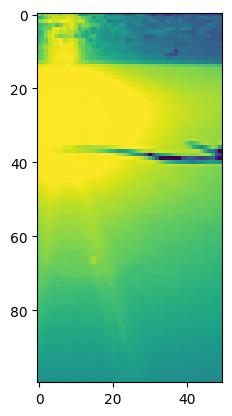

In [18]:
plt.imshow(image1[:,:50])
plt.savefig('image1_crop.png')
# dpi=  , transparent=True, bbox_inches='tight'

In [19]:
hdu = fits.PrimaryHDU(image1[:,:50])
hdu.writeto('image1_crop.fits', overwrite=True) # overwrite=True ; 덮어쓰기

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                  100                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

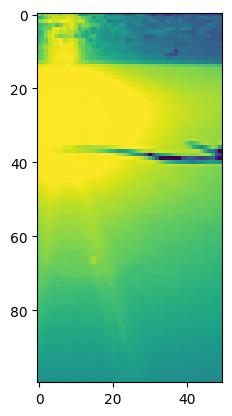

In [20]:
hdu = fits.open('image1_crop.fits')
plt.imshow(hdu[0].data)
print(hdu[0].header)
hdu.close()

In [21]:
hdu = fits.PrimaryHDU(image1[:,:50])
hdu.header['AUTHOR'] = 'AC'
hdu.writeto('image1_crop.fits', overwrite=True) # overwrite=True ; 덮어쓰기

hdu = fits.open('image1_crop.fits')
print(hdu[0].header)
hdu.close()

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                  100                                                  EXTEND  =                    T                                                  AUTHOR  = 'AC      '                                                            END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### `scipy.interploate.interp2d`
<img src='interp2d.png' width='600'>

scipy version 유의! interp2d 사용하고 싶다면 1.14.0 이전 scipy를 설치.

Ex) `conda install scipy=1.10.1`

자세한 anaconda 가상환경 관리는 TA_Week3.ipynb 참조

scipy version 확인하는 방법

```python
import scipy
print(scipy.__version__)
```
---

### `scipy.interpolate.griddata`
<img src='griddata.png' width='600'>

### Appendix - `plt.errorbar()`

<ErrorbarContainer object of 3 artists>

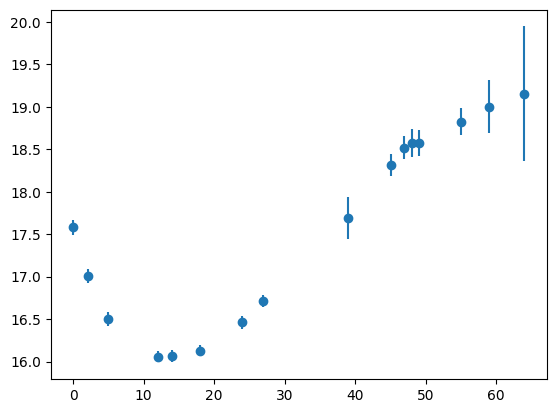

In [22]:
plt.errorbar(x = df['JD_from0'], y = df['Mag'], yerr=5*df['dMag'], fmt='o')

<ErrorbarContainer object of 3 artists>

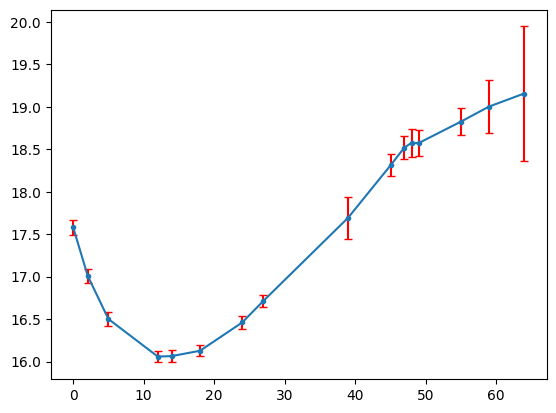

In [23]:
plt.errorbar(x = df['JD_from0'], y = df['Mag'], yerr=5*df['dMag'], 
             fmt='o-', markersize=3, ecolor='red', capsize=3, label='Mag error')

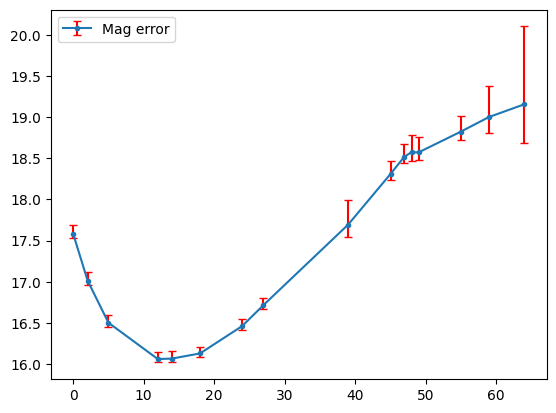

In [24]:
plt.errorbar(x = df['JD_from0'], y = df['Mag'], yerr=[3*df['dMag'], 6*df['dMag']],  # yerr = [하한, 상한]
             fmt='o-', markersize=3, ecolor='red', capsize=3, label='Mag error')
plt.legend()